# Biweekly Check-in 2: LSTMs and TabNet
# Jacob Tiede
## Working with Text Data:
For this week I wanted to get some experience working with two new kinds of data: sequential data and tabular data. To this end I will start this report by working with text data. I will be working with data found here: https://www.kaggle.com/c/nlp-getting-started/data?select=train.csv, which is a dataset for disaster classification of tweets, but before we get to that let's look at a state of the art neural net used for these kinds of problems: a long-term short-term memory (LSTM) neural network.
## LSTMs
I'll start by reviewing an article on LSTMs found here: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21. This article mentions that LSTMs are a slightly modified version of recurrent neural networks (RNNs), so it is worth taking a brief aside to research these as well:
### Aside: RNNs
For this section I will be using this article as a guide: https://towardsdatascience.com/recurrent-neural-networks-d4642c9bc7ce. The article details that RNNs seek to solve 2 important problems with conventional neural nets and series data. The first being the shape of the input to an RNN need not be a fixed number, and the second being that an RNN can find relationships in a temporal sense (i.e. it can establish a relationship between inputs that it receives at different time steps). The first is solved by only applying a weight matrix $W_x$ (and presumably a non-linearity) to a small part of the input (maybe a single word for text classification) which will then give what is called the "hidden state" of that portion of the input. This is then multiplied with another weight matrix $W_y$ (and non-linearity) to give the first output. Since $W_x$ and $W_y$ stay the same for every input this scheme can be used on inputs of arbitrary size. The second problem (of remembering prior inputs in time) is solved by adding a third weight matrix $W_h$ which takes the hidden state for the previous input and adds $W_h*hidden-state-activation$ to the hidden state of the next input. More concretely, for the nth input to this scheme our hidden state $h_n$ would be $g_1(W_hh_{n-1})+g_2(W_xx_n)$ where $x_n$ is the nth input, and $g_1$ and $g_2$ are functions. This means that as we parse through the input we are propagating the prior hidden states through the neural network. It is worth noting that this is describes a unidirectional RNN, but there is such a thing as a bidirectional RNN (which calculates 2 hidden states, one which will propagate backwards and one the propagates forward), but these are not relevant to our discussion of LSTMs at this time.
### Back to LSTMs
Moving back to the original article (https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21) we can see that LSTMs are attempting to solve several problems with RNNs most of which are centered around long inputs. Typical RNNs have trouble propagating its memory (the hidden state) through long inputs, so for inputs of say a paragraph of text an RNN will lose information from the beginning. These neural nets are also prone to vanishing and exploding gradients which LSTMs will also attempt to solve by implementing gates into the framework. These gates are a means for the neural network to forget irrelevant information and only remember what is truly important to whatever task it is being trained for. Therefore, it should seem fitting that our first gate is called a "forget gate". This gate will take the current input concatenated with the prior hidden state (call this concatenated vector $x_i+h_{i-1}$ and push it through a sigmoid function (effectively giving the neural net the ability to choose to "forget" certain aspects of either the input or the prior hidden state since these could either be squished to zero or retained close to one) call the output of this forget gate $f_i$. We then move to an input gate where $x_i+h_{i-1}$ is put through both a sigmoid and a tanh function which creates two vectors which are then multiplied point-wise together producing an output that we'll call $I_i$. $f_i$ is then multiplied pointwise with the previous cell's state giving a vector $l_i$ which is then added point-wise to $I_i$ which gives the cell state of our current cell $c_i$. This then takes us to the final gate: the output gate. This gate will first compute two vectors: first it finds $sigmoid(x_i+h_{i-1})$, then it computes $tanh(c_i)$. These two vectors are then multiplied together pointwise which gives the hidden state of this cell.
### Implementation
For this section I will use this tutorial from the pytorch documentation as a guide: https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html. The first thing to note is that we can create an "encoding" that is trainable, where, rather than just one hot encoding each word into a vector, the program learns how to produce a useful encoding for this task (ie the encoding is trainable). The other major note is that since my neural net only needs to provide a single classification for the tweet as a whole (is there or is there not a disaster) we will only use the last output of the LSTM (ran through a sigmoid) to make our prediction.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
print("Is a GPU available?")
torch.cuda.is_available()

Is a GPU available?


True

In [2]:
#Let's load the data into python
trainData = pd.read_csv("./Tweet_train.csv")
#To get an idea of what the data contains we will print the first few rows:
print(trainData.head())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  


In [3]:
#extract the target:
trainTarget = trainData['target'].to_numpy()
#We'll only use the text to train (no keyword or id)
trainText = trainData['text'].to_numpy()
from sklearn.model_selection import train_test_split
trainText, testText, trainTarget, testTarget = train_test_split(trainText, trainTarget, test_size=0.1, random_state=4)

testTarget = torch.from_numpy(testTarget).cuda()
trainTarget = torch.from_numpy(trainTarget).cuda()

In [8]:
#We now need to both separate all of our sentences into words and represent them with a vector, we will do this with a class

#This function takes a string and separates it into words
def sentToWords(text):
    words = []
    temp = ""
    for i in text:
        if i != " ":
            temp = temp + i
        else:
            words.append(temp)
            temp = ""
    words.append(temp)
    return words

#takes a vector of strings and splits them into words, which then become a vocab dictionary with an index mapping
def splitSentences(text):
    words = []
    temp = ""
    for para in text:
        for i in para:
            if i != " ":
                temp = temp + i
            else:
                words.append(temp)
                temp = ""
        words.append(temp)
    mapping = {}
    k = 0
    for word in words:
        if word not in mapping.keys():
            mapping[word] = k
            k+=1
    return mapping
vocab = splitSentences(trainText)

#converts a sentence to a list of indexes based on a vocab dictionary
def sentenceToIdx(sent, mapping):
    temp = sentToWords(sent)
    mappedSentence = []
    for i in temp:
        if i in mapping.keys():
            mappedSentence.append(mapping[i])
        else:
            mappedSentence.append(len(mapping.keys()))
    return torch.tensor(mappedSentence).view(1,-1)

#create the LSTM Classifier, see https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMClassifier, self).__init__()
        #the dimension of the hidden state of our LSTM
        self.hidden_dim = hidden_dim
        #create the trainable word embedding
        self.word_embeddings = nn.Embedding(vocab_size+1, embedding_dim)
        
        #we only have a single LSTM layer in this model
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        #from the pytorch tutorial, they were trying to tag words with things like "noun" or "verb", but I will only use the final output, so a better name might
        #be hidden to prediction, but for the sake of following the notation of the tutorial I will keep the naming
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        
    def forward(self, sentence):
        #embed the word vectors into a smaller dimension space
        embeds = self.word_embeddings(sentence)
        #send this through our LSTM layer
        lstm_out, _ = self.lstm(embeds.view(sentence.shape[1], 1, -1))
        #tag space is the "tags" of each word, but remember that we only actually need to apply this neural net to the last "word" in the sentence (the final output of the LSTM)
        tag_space = self.hidden2tag(lstm_out.view(sentence.shape[1], -1)[sentence.shape[1]-1,:])
        out = torch.sigmoid(tag_space)
        return out
model = LSTMClassifier(int(np.floor(np.power(len(vocab.keys()), 1/4))), 6, int(len(vocab.keys())), 1)
model.cuda()

LSTMClassifier(
  (word_embeddings): Embedding(34059, 13)
  (lstm): LSTM(13, 6)
  (hidden2tag): Linear(in_features=6, out_features=1, bias=True)
)

In [9]:
#train the model similarly to how we have before
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
epochs = 50
for epoch in range(epochs):
    running_loss = 0
    temp = torch.randperm(trainText.shape[0])
    trainTarget = trainTarget[temp]
    trainText = trainText[temp]
    
    for j in range(int(trainText.shape[0])):
        optimizer.zero_grad()
        input = sentenceToIdx(trainText[j], vocab).cuda()
        output = model(input)
        temp = trainTarget[j]
        loss = criterion(output.float(), temp.float())
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j == trainText.shape[0] -1 and epoch % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, j + 1, running_loss / trainText.shape[0]))
            acc = 0
            for k in range(int(testText.shape[0])):
                input = sentenceToIdx(testText[k], vocab).cuda()
                output = model(input)
                if output >= .5:
                    output = 1
                else:
                    output = 0
                if output == testTarget[k]:
                    acc += 1
            print("Test set accuracy for this epoch: " + str(acc/testText.shape[0]))

print('Finished Training')

C:\Users\JAT\anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


[10,  6851] loss: 0.562
Test set accuracy for this epoch: 0.6876640419947506
[20,  6851] loss: 0.409
Test set accuracy for this epoch: 0.7217847769028871
[30,  6851] loss: 0.290
Test set accuracy for this epoch: 0.7270341207349081
[40,  6851] loss: 0.199
Test set accuracy for this epoch: 0.7322834645669292
[50,  6851] loss: 0.131
Test set accuracy for this epoch: 0.7362204724409449
Finished Training


### Final Thoughts
LSTMs performed well for this task, but I wonder if there is a way to get more accuracy, for instance there might be misspelled words in the test data which might make classification difficult.
## Changing Gears: TabNet
I now want to learn how to use neural nets on yet another type of data: tabular data. To do this I will review Google's TabNet paper (https://arxiv.org/pdf/1908.07442.pdf). This paper seeks to create a deep neural network that replicates important aspects from both tree-based methods for tabular data as well as advantages seen in fields like computer vision (like end-to-end deep learning). This is accomplished by leveraging intuition about how a neural net can be used to emulate a tree, as well as this idea of attention in deep learning. To start the authors give a motivating example of how a neural net can simulate a simple decision tree which uses a lot of the ideas that will come into play for the full model, so I think it is worth going into detail for this example (Figure 3 in the paper):
### Aside: Using Neural Nets to Simulate Trees:
Consider a set of tabular data with two columns labeled $(x_1, x_2)$ a decision tree will find a set of if-then statements that will determine how to classify points (eg: if $x_1 > 1$ and if $x_2 >1$ then classify $0$). These split points can be thought of as hyperplanes in many dimensions (or in our case a straight line on the $x_1$ $x_2$ plane like $x_1 = 1$). To replicate this behavior in a neural net we should take note that any split point (in the 2D example) is either a horizontal or vertical line (this is generalized later). This means that our neural net should output two vectors (in our case) that represent these decision boundaries (which can then be summed and softmaxed to give a prediction). These vectors will represent on which side of each decision boundary we are for each dimension (in this case 2 dimensions).  
 
Consider a single input $(x_{1i},x_{2j})$ and two different neural nets each of which only see one of the features (again see figure 3 in the paper). This feature selection is accomplished using a mask which is a vector of size $D$ (where $D$ is the number of dimensions in your data) which will be elementwise multiplied with each row of your data. So, in our example to extract the first column our mask would contain a vector $(1,0)$ which, after multiplying with our input $(x_{1i},x_{2j})$, will give $(x_{1i},0)$. This means that our model will need two neural nets, one with a mask containing the vector $(1,0)$ before it and the other with a mask containing the vector $(0,1)$ before it. Let's quickly follow this example through one branch of our structure using the notation from the paper:  
 
We start with an input $(x_{1i},x_{2j})$ which will be passed through our first mask producing $(x_{1i},0)$. This is then passed through a neural net whose output size should be the number of classes you are trying to classify. Since two lines (one vertical and one horizontal) can partition a 2D plane into four distinct sections we will make this neural net have 4 output neurons. However, since this neural net needs only to tell us if we are above or below the a line in $x_1$ space we only need to encode 1 input to two outputs (one of which will be non-zero if we are above the line and one which will be non-zero if we are below the line). Therefore, our weights should be a vector of $[C_1, -C_1, 0, 0]$ with biases $[-aC_1, aC_1, -1, -1]$ in order to produce this behavior. So after running our input $x_{1i}$ through this we will get this vector:
$$
\begin{bmatrix}
C_1(x_{1i}-a)\\
C_1(-x_{1i}+a)\\
-1\\
-1
\end{bmatrix}
$$
Which is then passed through a ReLU function. Now, say that our line (that we are partitioning the $x_1,x_2$ plane with) is at $x_1 = 1$ to see how this vector indeed partitions our space consider a trained net with $a = 1$ and $C_1 > 0$ then, if $x_{1i} = 2$ our final vector would be:
$$
\begin{bmatrix}
C_1(2-1)\\
C_1(-2+1)\\
-1\\
-1
\end{bmatrix}
$$
which, after applying the ReLU becomes:
$$
\begin{bmatrix}
C_1\\
0\\
0\\
0
\end{bmatrix}
$$
So every input $x_{1i} > 1$ will always produce a vector with only 1 non-zero component, and that component will always be the first element of the vector. This will work similarly with the second neural net except it will only produce vectors with non-zero components in the third and fourth positions. The outputs of these two neural nets are then added together which will give a vector with two non-zero elements, which will tell you exactly where $(x_{1i},x_{2j})$ is relative to our decision boundaries. Now, it is clear to see that this could generalize easily to lines in multiple dimensions (i.e. a diagonal line in the $x_1,x_2$ plane) it would just require more complex weights, biases, and masks. This is fundamentally the behavior that TabNet is trying to emulate, but with added complexity. Now, before we continue it is pertinent to know what attention is in a deep learning context.
### Aside: Attention
To get a better understanding of attention I will summarize this blog post on the topic in this section: https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f. To properly summarize this article we can consider natural language processing again, as this is where the first attention mechanism was implemented. Consider again our LSTM network which takes a portion of an input (like a word of a sentence) and encodes it into both a hidden state and a cell state. For the purposes of this discussion consider a slightly different way of thinking where the hidden and cell states are the same state (which I will call the cell state). To do this would require a slight change in thinking, as well as a change to the internal gates of the LSTM block (these are called Gated recurrent units or GRUs, but I won't explain that for now), but for our purposes we can just think of each block or cell as something that takes a word in an outputs a single cell state. Now, we will consider translating a sentence with this network. More concretely, we want to take a sequence of words and turn it into another sequence of words with the same meaning in a different language. The way this problem was first solved was by taking the sequence of words and putting it through the first of two sequence models, and then using the output from the last cell in the first sequence model as the input to the second model to reconstruct the sentence in the target language. Using a diagram this looks like:  
 
sentence -> model 1 -> output vector from the last cell of model 1 -> model 2 -> output of each cell in model 2 is a word in the translation, and we go until we get a special "end translation" character  
 
This model runs into problems with memory, elements from the beginning of the sentence are lost, because we are only leveraging information from the very last cell of the first model. The way to solve this is to use all of the cell states across our whole first model, but how do we make the second model leverage all of the information while still understanding where it is in its translation? The answer is attention: for different stages of translation we want our second model to pay more attention to certain parts of the input. For instance, at the start of a translation you would pay more attention to the words in the beginning, which is exactly the behavior we want to replicate for this scheme. Using the notation from the article, we will first run the input sentence through our first model (the "encoder") which will produce a number of cell states $h_1,h_2,...,h_n$ which will then be fed into a fully connected neural net along with the previous state of the second model (the "decoder"). NOTE: if this is the first word to translate we will just feed the last cell state of the encoder in place of the state of the decoder. We do this because this lets the dense neural net know where in the translation we are, because the goal of this network is to output attention values (or how much attention we should pay each of the states $h_1,h_2,...,h_n$). This neural net calculates "attention" by giving an output of size n and having a softmax activation to get a list of probabilities $e_1,e_2,...,e_n$ that all represent the relative importance of each of the encoded states $h_1,h_2,...,h_n$. Element-wise multiplication of the $e$ vector and $h$ vector will then give the so-called "context vector" $e_1h_1, e_2h_2, ... , e_nh_n$. We then need to also tell the decoder exactly where we are in the translation so we will append a vector representing the last translated word to this context vector (or a special start character if this is the first word in the translation), and pass this concatenated vector to the decoder which will then give us our next word and cell state to be used in the cycle all over again.  
 
To summarize: attention is a way of leveraging more data without getting overwhelmed by irrelevant details, but more relevantly it is a way of identifying what information is actually important for a given computation. But the question still remains: how does TabNet leverage this concept?
### Attention in TabNet
Moving back to the paper (to reiterate the source: https://arxiv.org/pdf/1908.07442.pdf) we return to the idea of masks, but we note that a mask is very similar to the vector $e_1,e_2,...,e_n$ that was output by the attention neural net in our translation example. This is, in fact, where the attention mechanism lies, everytime we apply a mask we are choosing a subset of parameters that we are considering 'relevant', and this, much like the translation example, will be trained. We can now talk about the two fundamental building blocks of this model: Feature Transformers and Attention Transformer. We will start with the latter:
### Attention Transformers
The goal of these transformers is to take a representation of the input from a feature transformer and turn it into a mask. Using the notation of the paper: we will use the feature transformer on the initial data, which has dimension $BxD$ where $B$ is the batch size and $D$ is the number of columns in our data, and transform it into a vector of size $BxN_a$. This is now passed to our attention transformer which will turn it into a mask of size $BxD$. With this goal in mind we can define the neural net at this point:  
 
We start with a fully connected layer followed by batch normalization the output of which is multiplied by a "prior scales" function. This function is defined in the paper as:
$$
P[i] = \Pi_{j=1}^i (\gamma - M[j])
$$
Where $\gamma$ is a 'relaxation' parameter and $M[j]$ is the jth mask in our model. $P[0]$ is initialized to be all ones. This is then put through a function called a sparse max. I won't go into what exactly this is right now beyond saying that it is like softmax, but it tries to set low probabilities to zero without losing the desirable qualities of softmax (like differentiability). A good article on this topic can be found here: https://towardsdatascience.com/what-is-sparsemax-f84c136624e4. Sparsemax is desirable here because we would like to totally exclude columns if we can, so this allows our mask to do that. After applying this activation we will have the mask that we will use for the next layer, and for the sake of efficiency one can update prior scales by multiplying the stored prior scales by $\gamma - newMask$.
### Feature Transformers
These are built up from repeats of 3 layers: a fully connected layer, a batch normalization layer, and a gated linear unit non-linearity. In the paper each feature transformer was made of 4 repeats of these 3 layers, with residual connections between each layer, normalized by a coefficient of $\sqrt{.5}$. The paper also notes that some of the layers in these transformers should be consistent across the whole network, so we must reuse a subset of these layers throughout the model. It is also noted that there is a split operation performed in these transformers. This is simply splitting the output of this transformer into a decision and an input to the attention transformer. The input to the attention transformer has size $N_a$ and output prediction (decision) for this step will have dimension $N_d$. An important implementation note is that all of the batch normalizations in the feature transformers are what are called ghost batch normalizations which I think are worth talking about:
### Ghost Batch Normalization
For this section I will review the paper that originally presented ghost batch normalization found here: https://arxiv.org/pdf/1705.08741.pdf. To start let's detail a known problem in machine learning: the generalization gap. When using large batch sizes there is a 'degradation of generalization' in the performance of neural networks, in other words training accuracy might remain the same for large batch sizes, but there is a drop in accuracy on the test set (our model is not generalizing). This is not a problem for small batch sizes, but in order to use the full capability of modern GPUs the authors of the TabNet paper recommend using batch sizes as large as possible. Ghost batch normalization is one proposed solution to this problem. The paper on ghost mini batches (https://arxiv.org/pdf/1705.08741.pdf) finds that the distance of the final weights from their initialization position grows logarithmically with the number of gradient descent steps. Intuitively, taking fewer steps in gradient descent should make the model less accurate, but this result shows that this problem can be much larger than one might anticipate. With this hypothesis they show that it is indeed the case that our "generalization gap" stems from not doing as many gradient descent steps when using a larger batch size. This is perhaps a slight simplification, so it is worth noting that small mini-batches have another desirable property: stochastic noise. Since the input is smaller a small mini-batch has a larger variance which (according to the paper) has been found to encourage the weights to move out of steep minima and more toward a global minima. To mitigate these problems they propose the method ghost batch normalization.  
 
The goal of ghost batch normalization is to match the statistics of the step size when using a small batch. This will allow us to leverage all of the desirable properties of a small mini-batch for a large mini-batch. The way ghost batch normalization does this is by taking small "ghost" batches (using subsets of the mini-batch that it is processing), and does batch normalization on only those portions of the batch. For the training set it keeps track of the running average and standard deviation in the same way that normal batch normalization would to eventually use on the test set. This method should provide stochastic noise similar to that of small mini-batches, and the authors show that using it will close the generalization gap if we allow the model to perform more iterations of gradient descent.
### Overall Structure of TabNet
We now must consider the overall arrangement of transformers. To start, we receive data into our model, and we must first get our data's statistics under control. One of the advantages that the author's of TabNet outline is that this network is meant to run in so-called "end-to-end" deep learning, this means that we are assuming that we have not preprocessed our features in any way (other than making them numeric). This means that our features could be input with vastly different scales, and overall statistics, so the authors first get all of those things under control with a normal batch normalization layer. We then consider the first block of the model. The data is sent to a block with this structure:  
 
Data (size $BxD$) -> Feature Transformer -> Output of Feature Transformer (size $BxN_a+N_d$) -> split (creates two outputs, one of size $BxN_d$ and one of size $BxN_a$) -> one of these outputs is not needed for this step, specifically the $BxN_d$ sized output -> Feed split's $BxN_a$ output into the attention transformer -> Outputs mask of size $BxD$.  
 
From a qualitative perspective here's what's happening: the data is fed into the feature transformer which makes both a "decision" output ($BxN_d$) and an encoded representation of the data ($BxN_a$). In the first step we aren't making a decision, so we throw the decision output away. We then need to run the encoded features through the attention transformer. From this encoded representation the attention transformer figures out which features we need to pay the most attention to, and outputs a mask. It is also worth noting that the data we input to this layer is a copy of the data, because we need this data for each step of the model. This is then put into the next step of the model which is the real building block of the network. This step looks like this:  
 
Data (size $BxD$) -> pointwise multiplication with a mask (output of previous attention transformer) -> Feature Transformer -> Output of Feature Transformer (size $BxN_a+N_d$) -> split  
 
Each output of split now has a different path so we'll start by following the $BxN_d$ output:  
 
Split output (size $BxN_d$) -> ReLU -> add this output point-wise with the output of all the block ahead of it in the network -> Fully Connected layer -> softmax  
 
One can draw parallels between this scheme and residual learning in that we are sort of aggregating the outputs of many blocks together by adding them together. We will now follow the path of the other split output:  
 
Split output (size $BxN_a$) -> attention transformer -> Mask  
 
This is the same as it was for out first block. The next important part of the architecture is the ability for this model to give feature attribution.
### Feature Attribution in TabNet
In order to get the global importance of each feature to the decision of the model we need only to know the masks at each step, and the relative importance of each mask to the overall decision. Since we already have each mask (the output of the attention transformer) we just have to consider a way of gauging the relative importance of that mask to the final decision. To gauge this, the authors define an aggregation function (the box labeled "Agg" on figure 4 in the paper) as the sum of our decision matrix after we apply a ReLU non-linearity. More precisely: let the output of size $BxN_d$ after we apply the split operation to the output of a feature transformer be called $V_D$. To get the relative importance of a given mask we take $ReLU(V_D)$ and sum along each row to produce a vector $v_A$ of size $Bx1$. We can then take our mask $M_k$ (as the mask from the kth block of our model) of size $BxD$ and multiply each row by the corresponding row of $v_A$ which will give a matrix of the form:
$$
\begin{bmatrix}
m_{1,1}*v_1 &m_{1,2}*v_1  & ... & m_{1,D}*v_1\\
m_{2,1}*v_2 &m_{2,2}*v_2  & ... & m_{2,D}*v_2 \\
\vdots  & ... & \ddots   & \vdots \\
 m_{B,1}*v_B& m_{B,2}*v_B & ... &m_{B,D}*v_B
\end{bmatrix}
$$
Where $v_i$ is the ith element of $v_A$ and $m_{i,j}$ is the i,jth element of our mask $M_k$. If we call this new matrix $M_{new, k}$ we are almost done defining this aggregation. If our model has $N$ total decision blocks then we will let $M_{sum}$ be the point-wise sum of all of our $M_{new, k}$, in other words $\sum_{n=1}^NM_{new,n} = M_{sum}$. Then, to create the often desirable property that each row sums to 1, we will normalize this by dividing each element of each row of $M_{sum}$ by its corresponding row sum. This will give a new mask that corresponds to the relative importance of each feature in the model for each batch. One can then take the mean across the batch dimension to get a global importance of each feature. The final aspect of training one of these neural nets is self-supervised learning.
### Self-Supervised Learning
Self-supervised learning simply refers to using the data itself to sort of 'pre-train' a neural net, so that it has an idea of how different features of the dataset interact before it has even begun trying to predict something. For instance, if we had a dataset that had two columns, marital status and relationship status, with values like "married" or "not married" for the first column and "in a relationship" or "not in a relationship" for the second, then given that someone is married it would have to follow that they were in a relationship, and if someone is not in a relationship it should follow that they are not married. This presents a learnable correlation of TabNet, and it would be advantageous for TabNet to have some idea about what this correlation is before it attempts any predictions.  
 
To accomplish this the authors present a deceptively simple method. We are going to feed the model an incomplete dataset and try to make it predict values that we take out. This should teach the model correlations between columns without needing to generate more data. The way that we will do this is by taking our "encoded" representation (the output of TabNet) and feeding it into a decoder. More explicitly using the notation from the "Overall Structure of TabNet'' section, we will take the end product of the $BxN_d$ path of split, put it through a dense layer with output size $BxD$ and put it through a feature decoder. This feature decoder will just be N blocks of this pattern:  
 
Feature Transformer (output $BxN_a+N_d$) -> Fully Connected Layer (output $BxD$)  
 
Since we are allowed to have N steps in this decoder we just take the ouput of each step and add them together to get the reconstructed features. Now, with all of the theory out of the way we can work on an implementation.


### Implementation
#### Ghost Batch Normalization
Here I will detail each step of the implementation of TabNet. To start, we'll create the ghost batch normalization layer

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
print("Is a GPU available?")
torch.cuda.is_available()

Is a GPU available?


True

In [2]:
"""
ghostBN - creates a ghost batch norm layer as defined by https://arxiv.org/pdf/1705.08741.pdf

@initializaton: numCol - number of features in the data passed to ghostBN
                ghost_size - the size of each of the ghost batches, will choose 64 if no other value given
                Training - Tells us whether or not we are training
                
@methods:       forward(self, x): forward pass of our ghost batch normalization
                setTraining(self, x): tells ghost batch norm whether it is training or not, sets self.training
"""
class ghostBN(nn.Module):
    def __init__(self, numCol, training = True, ghost_size = 64):
        super(ghostBN, self).__init__()
        self.ghost_size = ghost_size
        self.numCol = numCol
        self.training = training
        
        # We note that ghost batch norm is just running a single batch norm layer over multiple portions of the input. This means that we can define ghost batch
        # norm in terms of a single batch norm layer that is applied to multiple parts of the input
        self.GBN = nn.BatchNorm1d(self.numCol)
    def forward(self, x):
        #GBN works in chunks during training, but on the whole thing if we are not training
        if self.training:
            #chunk the input data into a list of tensors that are all views of x, for an explanation of why we do this see the comments below this
            #see https://pytorch.org/docs/stable/generated/torch.chunk.html for tensor.chunk's specifics
            chunks = x.chunk(int(np.ceil(x.shape[0] / self.ghost_size)), dim = 0)
            #initialize a vector of outputs
            out = []
            #for each chunked view for our input data, append the result of running batch norm on it to out
            for i in chunks:
                out.append(self.GBN(i))

            #our final output is then the concatination of all of our outputs. We originally chunked it by row (effectively reducing the size of the mini batch)
            #as ghost minibatch intends to do, so we now have to rejoin them row-wise
            finalOut = torch.cat(out, dim=0)
        else:
            finalOut = self.GBN(x)
            
        #Below was my first attempt at writing this, and I'm only keeping it in to explain why it breaks Pytorch's back propogation. Notice how we are slowly 
        #changing x in place as we iterate through the array. Each of these "slice" operations have a backward step in pytorch, and each slice backward has
        #a gradient function that acts on all of x. By working on a single array sequentially we are creating new backpropogation steps in place that effect the
        #whole array, but we only actually modify a part of the array. This confuses Pytorches backpropogation since the first slice backward operation will
        #see many in place changes that it doesn't recognize, so we need to split the input into multiple arrays that we can run batch norm on separately so
        #Pytorch knows how to backpropogate, hence the "chunk" operation you see above. It is worth noting tat this method will actually work in forward prop.
        """
        if self.training:
            # the number of complete steps of size ghost_size we can take as we walk down the columns
            complete_steps = int(np.floor(self.batch_size/self.ghost_size))
            # need one extra iteration since we could have some remainder rows 
            for i in range(complete_steps+1):
                startInd = int(i*self.ghost_size)
                if i == complete_steps:
                    endInd = x.shape[0]
                else:
                    endInd = int((i+1)*self.ghost_size)
                x[startInd:endInd, :] = self.GBN(x[startInd:endInd, :])
        else:
            x = self.GBN(x)
        return x
        """
        return finalOut
    
    def setTraining(self, x):
        self.training = x


#### Sparse Max Implementation
Now is a good time to go more into depth about the sparse max function since we will need to implement this. We'll need two key results for this function to implement it in pytorch: the forward pass, and the backward pass (its derivative). We'll use the original paper (https://arxiv.org/pdf/1602.02068.pdf) to figure out what sparse max is doing. 
##### The Forward Pass
Sparse max is a function that maps vectors in $n$ dimensions to probabilities (specifically it maps these vectors to a probability simplex). Sparse max does this by finding the euclidean projection of a vector onto the probability simplex, which, the paper notes, has a high probability of hitting the boundary of the simplex which will make the resulting projection very sparse. This can be done in linear time with a simple algorithm (algorithm 1 in the paper, copied below):  
  
Input z  
Sort z in descending order as $z_{(1)}>=z_{(2)}>=...>=z_{(K)}$  
Let $k(z) = max(k \in [K] | 1 + kz_{(k)} > \sum_{j<=k}z_{(j)}$  
Let $\tau(z) = \frac{-1+\sum_{j<=k(z)}z(j)}{k(z)}$  
Return $P$ where $p_i = max(0, z_i-\tau(z))$  
  
Our output probability vector will be of dimension $K$, and $[K] = (1,2,...,K)$, so $k(z)$ finds the max value from 1 to K such that 1 + (specific value of k) * kth element of our vector z is > the cumulative sum of all of the previous elements of z. This means that $k(z)$ is some integer between 1 and K, so the definition of $\tau(z)$ should now make sense (at least enough to implement it). 
##### The Backward Pass
Working from the Jacobian section of the paper we can see the formula for the derivative is (this is the formula we'll need for gradient descent, so it is actually the jacobian multiplied by a vector $v$):
$$
J(z)*v = s \odot (v-\hat{v}), \hat{v} = \frac{\sum_{j \in S(z)} v_j}{|S(z)|}
$$
Where $S(z)$ are the non-zero elements of sparse max, $s$ is an indicator variable of size K (the size of the output) with a 1 if the jth element had a non-zero sparse max value in the output when we ran the forward pass, and $\odot$ is element-wise multiplication. This can actually be computed very quickly since we will have already calculated $S(z)$ (and implicitly $s$) in the forward pass. We can now implement this function, but to do so we will need to implement it as a new autograd function in Pytorch, a good tutorial for this can be found here: https://pytorch.org/tutorials/beginner/examples_autograd/two_layer_net_custom_function.html

In [3]:
#NOTE: from the pytorch documentation, we must define an alias when using this later in the code like: sparse_max = sparseMax.apply
class sparseMax(torch.autograd.Function):
    #static methods are used when we don't need to access a specific instance of a class, ctx will be context that can be saved for later use
    #portions of the forward code were inspired by the python code for the forward pass given here: https://towardsdatascience.com/what-is-sparsemax-f84c136624e4
    #z is assumed to have a shape of (mini batch size, # of features)
    @staticmethod
    def forward(ctx, z):
        # Step 1: sort z
        z_sorted, _ = torch.sort(z, dim = 1, descending = True)
        
        # Step 2: find k(z)
        # first create [K]
        bracketK = torch.arange(start = 1, end = z.shape[1] + 1).view(1, z.shape[1]).cuda()
        # we would like to do this without a for loop (to be efficient), so first we will find all of the 1+[K]*z_k values
        kz = 1 + bracketK*z_sorted
        # now we must find the cumulative sum of z_j
        z_sum = torch.cumsum(z_sorted, dim = 1)
        # now we find all of the valid k values
        k_valid = kz > z_sum
        # find the last value for each part of the mini-batch where k_valid is true, this will give us our k(z) 
        val_rows, val_cols = torch.where(k_valid)
        k_z = torch.zeros(z.shape[0],1).cuda()
        for i in range(z.shape[0]):
            if len(val_cols[val_rows == i]) == 0:
                k_z[i,:] = 1
            else:
                k_z[i,:] = torch.torch.max(val_cols[val_rows == i]) + 1
        
        # Step 3: compute T(z)
        Tz = torch.zeros(z.shape[0],1).cuda()
        for i in range(z.shape[0]):
            Tz[i, :] = (z_sum[i, int(k_z[i,0] - 1)] - 1)/k_z[i,0]
        
        # Step 4: find the output
        p = torch.zeros(z.shape[0], z.shape[1]).cuda()
        for i in range(z.shape[1]):
            p[:,i],_ = torch.max(torch.cat((z[:,i].view(z.shape[0],1) - Tz, torch.zeros(z.shape[0],1).cuda()), dim = 1), dim = 1)
        ctx.save_for_backward(p > 0)
        return p
    #grad_output are the gradients with respect to the loss for the layer ahead of this one
    @staticmethod
    def backward(ctx, grad_output):
        # Read the cached tensor from forward propagation
        input, = ctx.saved_tensors
        # We clone the prior gradients so that we don't accidentily modify them in place
        grads = grad_output.clone()
        v_hat = torch.sum(input* grads, dim = 1)/torch.sum(input, dim = 1)
        v_hat = v_hat.view(input.shape[0], 1)
        grads = input*(grads - v_hat)
        return grads
        

Here's a couple of quick tests to make sure that sparse max is working as intended:

In [4]:
sparse_max = sparseMax.apply
x = torch.rand(3,4).cuda()
y = sparse_max(x)
print("Here is what sparse max outputs for a random input x: ")
print(y)
print("The sum of each row, this should be 1 for all of the elements in the batch: ")
print(torch.sum(y, dim = 1))


Here is what sparse max outputs for a random input x: 
tensor([[0.5724, 0.3843, 0.0433, 0.0000],
        [0.0448, 0.2056, 0.2438, 0.5058],
        [0.3507, 0.1684, 0.3263, 0.1546]], device='cuda:0')
The sum of each row, this should be 1 for all of the elements in the batch: 
tensor([1.0000, 1.0000, 1.0000], device='cuda:0')


Notice that sparse max has pushed some of the probabilities to 0. With this implementation out of the way we can now move on to implementing the attention transformer:

#### Attention Transformer


In [5]:
"""
attTransformer -- defines an attention transformer using the scheme presented in https://arxiv.org/pdf/1908.07442.pdf 
V2

@initialization: n_a - the input dimension of the attention transformer
                 n_out - the number of dimensions the attention transformer outputs, this should be a mask so it should be the same dimension as the data
                 gamma - the relaxation parameter in the prior scales function, initialized to 1
                 
@methods:        forward(self, x): the forward pass through this transformer, assume x is of the form (batch_size, n_a)
                 getPriorScales(self): returns the output prior scales to be used in the next attention transformer
                 setS(self, x): If we are in the self supervised step we will tell our attention transformer which features to use in the first mask
                 setTraining(self, x): sets the training variable to x, will tell our model to adjust during validation
"""
class attTransformer(nn.Module):
    def __init__(self, n_a, n_out, gamma = 1):
        super(attTransformer, self).__init__()
        #Set params
        #-----------------------------
        self.n_a = n_a
        self.n_out = n_out
        self.gamma = gamma
        #The fully connected layer that will take n_a features and create an output with the same dimensions as our data
        self.FC = nn.Linear(n_a, n_out)
        #Our ghost batch normalization layer
        self.GBN = ghostBN(n_out)
        #only set if we are self-supervised training
        self.S = None
        #Tells us whether or not to use training methods or switch of evaluation methods
        self.training = True
        #-----------------------------
        self.prior_scales = None
            
    def forward(self, x):
        #check if we need to initialize prior_scales
        if self.prior_scales == None:
            self.prior_scales = torch.ones(x.shape[0], self.n_out)
            self.prior_scales = self.prior_scales.cuda()
        #if our data is not evenly divisible by our batch size the last prior scales might have a different size in the batch dimension
        if self.prior_scales.shape[0] != x.shape[0]:
            self.prior_scales = self.prior_scales[0:x.shape[0], :]
        #If we are not training we need to tell GBN to behave differently
        if self.training == False:
            self.GBN.setTraining(False)
        #start by feeding our data into the fully connected layer, then use ghost batch-normalization
        x = self.GBN(self.FC(x))
        #check if we are self-supervised learning
        if self.S == None:
            #point-wise multiply x by prior scales
            x = self.prior_scales*x
        else:
            #multiplying by 1-S will force the attention transformer to focus on using features we know
            x = (1-self.S)*self.prior_scales*x
        #Use sparse max as the activation
        sparse_max = sparseMax.apply
        x = sparse_max(x)
        #update prior_scales for the next layer
        self.output_prior_scales = (self.gamma - x)*self.prior_scales
        return x
        
    def getPriorScales(self):
        return self.output_prior_scales
    
    def setS(self, x):
        self.S = x
        
    def setTraining(self, x):
        self.training = x
    
    def setPriorScales(self, x):
        self.prior_scales = x

#### Feature Transformer
The only somewhat strange thing about this implementation is that these feature transformers have a number of shared layers. In the paper's implementation 2 shared decision layers are used in each model, and two decision specific layers. This means that our feature transformer class will need to be able to input shared layers as well as get them for use in other parts of the model. Implementing this:

In [6]:
"""
featTransformer -- defines a feature transformer using the cheme presented in https://arxiv.org/pdf/1908.07442.pdf

@initialization: n_a - the number of features that will be passed to the attention transformer
                 n_d - the number of features that will comprise a decision (this will hold our predictions for this step)
                 num_features - the number of features in the data that we give to this transformer
                 shared_layers - the layers that will be shared across feature transformers, for the first feature transformer this will be None
                 num_layers_shared - the number of layers shared across feature transformers
                 num_layers_independent - the number of layers that are different for each feature transformer
                 
@methods:        forward(self, x): the forward pass of the model
                 getSharedLayers(self): returns the shared layers for this model
                 setTraining(self, x): sets the training variable which tells our model whether we are in the training or validation steps
"""
class featTransformer(nn.Module):
    def __init__(self, n_a, n_d, num_features, shared_layers = None, num_layers_shared = 2, num_layers_independent = 2):
        super(featTransformer, self).__init__()
        #Set params
        #-----------------------------
        self.n_a = n_a
        self.n_d = n_d
        self.num_features = num_features
        #Keep track of whether or not we are training the model
        self.training = True
        #the shared layers will be passed to all of our feature transformers
        self.num_layers_shared = num_layers_shared
        self.shared_layers = shared_layers
        #-----------------------------
        
        #check if this is the first feature transformer, if it is we must initialize the shared layers
        if self.shared_layers != None:
            self.shared_layers = shared_layers
        else:
            self.shared_layers = nn.ModuleList([nn.Linear(self.num_features, 2*(self.n_a + self.n_d))])
            self.shared_layers.append(ghostBN(2*(self.n_a+self.n_d)))
            for i in range(self.num_layers_shared - 1):
                self.shared_layers.append(nn.Linear(self.n_a + self.n_d, 2*(self.n_a + self.n_d)))
                self.shared_layers.append(ghostBN(2*(self.n_a+self.n_d)))
                
        #set independent layers for this model
        self.num_layers_independent = num_layers_independent
        self.independent_layers = nn.ModuleList([])
        for i in range(self.num_layers_independent):
            self.independent_layers.append(nn.Linear(self.n_a + self.n_d, 2*(self.n_a + self.n_d)))
            self.independent_layers.append(ghostBN(2*(self.n_a+self.n_d)))
        
    def forward(self, x):
        if self.training == False:
            for i in range(self.num_layers_shared):
                k = i*2
                self.shared_layers[k+1].setTraining(False)
            for i in range(self.num_layers_independent):
                k = i*2
                self.independent_layers[k+1].setTraining(False)
                
        # Sets the scaling for the residual normalization of the network
        residual_scale = torch.sqrt(torch.tensor(.5)).cuda()
        x_mem_bool = False
        # Iterate through the shared layers
        for i in range(self.num_layers_shared):
            #each shared layer has two sub layers: a linear and a ghost batch norm, so we iterate 2 at a time
            k = i*2
            x = self.shared_layers[k+1](self.shared_layers[k](x))
            x = F.glu(x, dim = 1)
            #check if we have an x in memory
            if x_mem_bool:
                #add the residual connection, normalizing with the suggested residual scale from the paper
                x = (x + x_mem) * residual_scale
            #save prior x to memory and set x_mem_bool to true (assuming it isn't already)
            x_mem_bool = True
            x_mem = x.clone()
        
        # Iterate through the transformer specific layers
        for i in range(self.num_layers_independent):
            k = i*2
            x = F.glu(self.independent_layers[k+1](self.independent_layers[k](x)), dim = 1)
            x = (x + x_mem) * residual_scale
            x_mem = x.clone()
        return x
    
    def getSharedLayers(self):
        return self.shared_layers
    
    def setTraining(self, x):
        self.training = x

#### Feature Decoder
We'll now implement a decoder for self-supervised training.

In [7]:
"""
tabNetDecoder -- defines a decoder for self-supervised training of TabNet as presented here https://arxiv.org/pdf/1908.07442.pdf

@initialization: input_dim - the dimension of the output of the encoder, this should be the same dimension as the input to the shared layers in our feature 
                             encoders
                 output_dim - the dimension that our decoder will output, this should be the same dimension as the dataset that we work with
                 parameters used in feature transformers: n_a, n_d, shared_layers, num_layers_shared, num_layers_independent
                 num_decode_blocks - the number of decoding blocks that we will independently feed the output of the encoder to
                 
@methods:        forward(self, x): the forward pass for the model
                 setS(self, x): set the boolean mask S for selecting which features we are predicting 
"""
class tabNetDecoder(nn.Module):
    def __init__(self, input_dim, output_dim, n_a, n_d, shared_layers = None, num_layers_shared = 2, num_layers_independent = 2, num_decode_blocks =2):
        super(tabNetDecoder, self).__init__()
        #initialize params
        #-----------------------------
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.S = None
        self.n_a = n_a
        self.n_d = n_d
        self.shared_layers = shared_layers
        self.num_layers_shared = num_layers_shared
        self.num_layers_independent = num_layers_independent
        self.num_decode_blocks = num_decode_blocks
        #-----------------------------
        
        #construct the net:
        #The decoder will be composed entirely of feature transformers followed by linear nets
        
        #make the feature transformers
        self.featureTransformers = nn.ModuleList([])
        for i in range(self.num_decode_blocks):
            self.featureTransformers.append(featTransformer(self.n_a, self.n_d, self.input_dim, 
                                                            self.shared_layers, self.num_layers_shared, self.num_layers_independent))
            
        #make the dense layers
        self.FCLayers = nn.ModuleList([])
        for i in range(self.num_decode_blocks):
            self.FCLayers.append(nn.Linear(self.n_a+self.n_d, self.output_dim))
            
    def forward(self, x):
        #make a list to keep track of the copies of the data that we will need, because the input to each feature transformer must be the same data
        #so we have to avoid in-place operations being done to the original x
        xList = []
        #forward prop through each set of feature transformer -> dense
        for i in range(self.num_decode_blocks):
            #append a copy of x to our list, to be used as our inputs and outputs for the forward prop
            xList.append(x.clone())
            xList[i] = self.featureTransformers[i](xList[i])
            xList[i] = self.FCLayers[i](xList[i])
        
        #sum all of the outputs of all the layers
        first = True
        for i in xList:
            if first:
                summation = i
                first = False
            else:
                summation += i
                
        #return our final sum with only the features we are trying to predict as non-zeros
        return summation*self.S
            
    def setS(self, x):
        self.S = x

#### The Full Model
We'll now implement a model captable of self-supervision, and prediction.

In [8]:
"""
TabNet -- Defines TabNet as described by: https://arxiv.org/pdf/1908.07442.pdf

@initialization: input_dim - the number of dimensions in the data
                 output_dim - the number of dimensions in the prediction output
                 n_a - the number of variables to feed into attention transformers
                 n_d - the number of variables to output in the decision step of our feature transformers
                 gamma - used in attention transformers
                 num_layers_shared - used in feature transformers
                 num_layers_independent - used in feature transformers
                 num_decode_blocks - the number of feature transformers that our decode step should have
                 num_encode_blocks - the number of feature transformer -> attention transformer -> mask blocks we should have
                 
@methods:        forward(self, x): the forward pass of the model
                 setS(self, x): tell the model what features we are predicting in the self-supervised step
                 setTraining(self, x): tell our model whether or not we are training
                 getMasks(self): returns all of the masks in the current model
                 featureAttribution(self): preform feature attribution as described by the paper
"""
class TabNet(nn.Module):
    def __init__(self, input_dim, output_dim, n_a, n_d, gamma = 1.5, num_layers_shared = 2, num_layers_independent = 2, num_decode_blocks = 4, num_encode_blocks = 4):
        super(TabNet, self).__init__()
        #initialize params
        #-----------------------------
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.n_a = n_a
        self.n_d = n_d
        self.num_layers_shared = num_layers_shared
        self.num_layers_independent = num_layers_independent
        self.num_decode_blocks = num_decode_blocks
        self.num_encode_blocks = num_encode_blocks
        self.gamma = gamma
        
        self.S = None
        self.training = True
        #-----------------------------
        
        #BN1 is the normal batch norm that is apply to the input data before it is used by the net
        self.BN1 = nn.BatchNorm1d(self.input_dim)
        #start by defining our feature transformers for encoding the data
        self.enFeatTransformers = nn.ModuleList([])
        for i in range(self.num_encode_blocks):
            if i == 0:
                self.enFeatTransformers.append(featTransformer(self.n_a, self.n_d, self.input_dim, None, self.num_layers_shared, 
                                                              self.num_layers_independent))
                shared_layers = self.enFeatTransformers[i].getSharedLayers()
            else:
                self.enFeatTransformers.append(featTransformer(self.n_a, self.n_d, self.input_dim, shared_layers, self.num_layers_shared, 
                                                              self.num_layers_independent))
        
        #define our attention transformers for the encoded data
        self.enAttTransformers = nn.ModuleList([])
        for i in range(self.num_encode_blocks):
            if i == 0:
                self.enAttTransformers.append(attTransformer(self.n_a, self.input_dim, self.gamma))
            else:
                self.enAttTransformers.append(attTransformer(self.n_a, self.input_dim, self.gamma))
                
        #define the decoder for use when we are self-supervised training
        self.decoder = tabNetDecoder(self.input_dim, self.input_dim, self.n_a, self.n_d, shared_layers, self.num_layers_shared, 
                                     self.num_layers_independent, self.num_decode_blocks)
        
        #define two fully connected layers, one for when we are making predictions, and one for when we are in the self-supervised step
        self.FCPredict = nn.Linear(self.n_d, self.output_dim)
        self.FCSupervised = nn.Linear(self.n_d, self.input_dim)
        
    def forward(self, x):
        #start by feeding our input through a basic batch norm layer
        x = self.BN1(x)
        #initialize a list that will keep track of all of clones of x, this is because we must feed the same data into each step of the model so
        #we have to avoid in-place operations
        x_list = []
        #we will want to keep track of all of the masks for both the regularization parameter defined below, and the attribution step
        self.masks = []
        #keep track of the decision vector at each point to use in the attribution phase
        self.decisions = []
        #initialize a vector of all zeros that will keep track of the sum of each of our decisions
        finalDecision = torch.zeros(x.shape[0], self.n_d).cuda()
        
        #check if we are in the self-supervised step of training
        if self.S == None:
            for i in range(self.num_encode_blocks):
                #clone x and only use this clone throughout the propogation
                x_list.append(x.clone())
                #we need to treat the first and last blocks differently
                if i == 0:
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    #we only create a mask for the first layer
                    att = x_list[i][:, 0:self.n_a]
                    self.masks.append(self.enAttTransformers[i](att))
                    #we need to keep track of prior scales as we go
                    prior_scales = self.enAttTransformers[i].getPriorScales()
                    
                    
                elif i < self.num_encode_blocks - 1:
                    #set the prior scales term based off of the i-1 attention transformer
                    self.enAttTransformers[i].setPriorScales(prior_scales)
                    #apply the mask
                    x_list[i] = x_list[i]*self.masks[i-1]
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    #need both the attention vector and decision vector this time
                    att = x_list[i][:, 0:self.n_a]
                    dec = F.relu(x_list[i][:,self.n_a:self.n_a+self.n_d])
                    #keep track of the decision, and also make it contribute to the final decision
                    self.decisions.append(dec)
                    finalDecision += dec
                    #keep track of the mask
                    self.masks.append(self.enAttTransformers[i](att))
                    #update prior scales
                    prior_scales = self.enAttTransformers[i].getPriorScales()
                    
                    
                else:
                    x_list[i] = x_list[i]*self.masks[i-1]
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    #only need a decision for the last step
                    dec = F.relu(x_list[i][:,self.n_a:self.n_a+self.n_d])
                    self.decisions.append(dec)
                    finalDecision += dec
            #check whether to use a softmax or sigmoid for our predictions
            if self.output_dim > 1:
                finalDecision = torch.softmax(self.FCPredict(finalDecision), dim = 1)
            else:
                finalDecision = torch.sigmoid(self.FCPredict(finalDecision))
        #if we are in the self-supervised section
        else:
            #forward prop as before
            for i in range(self.num_encode_blocks):
                x_list.append(x.clone())
                if i == 0:
                    self.enAttTransformers[i].setS(self.S)
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    att = x_list[i][:, 0:self.n_a]
                    self.masks.append(self.enAttTransformers[i](att))
                    prior_scales = self.enAttTransformers[i].getPriorScales()
                elif i < self.num_encode_blocks - 1:
                    self.enAttTransformers[i].setPriorScales(prior_scales)
                    self.enAttTransformers[i].setS(self.S)
                    x_list[i] = x_list[i]*self.masks[i-1]
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    att = x_list[i][:, 0:self.n_a]
                    dec = F.relu(x_list[i][:,self.n_a:self.n_a+self.n_d])
                    self.decisions.append(dec)
                    finalDecision += dec
                    self.masks.append(self.enAttTransformers[i](att))
                    self.enAttTransformers[i].setPriorScales(prior_scales)
                else:
                    self.enAttTransformers[i].setS(self.S)
                    x_list[i] = x_list[i]*self.masks[i-1]
                    x_list[i] = self.enFeatTransformers[i](x_list[i])
                    dec = F.relu(x_list[i][:,self.n_a:self.n_a+self.n_d])
                    self.decisions.append(dec)
                    finalDecision += dec
            finalDecision = self.FCSupervised(finalDecision)
            
            #decode the decision
            self.decoder.setS(self.S)
            finalDecision = self.decoder(finalDecision)
        return finalDecision
    
    def setS(self, x):
        self.S = x
        
    def setTraining(self, x):
        self.training = x
        
    def getMasks(self):
        return self.masks
    
    def featureAttribution(self):
        v_A = torch.zeros(self.masks[0].shape[0], len(self.decisions)).cuda()
        for i in range(len(self.decisions)):
            v_A[:,i] = torch.sum(self.decisions[i], dim = 1)
        M_sum = torch.zeros(self.masks[0].shape[0], self.input_dim).cuda()
        for i in range(len(self.masks)):
            if i == len(self.masks)-1:
                M_sum[0:self.masks[i].shape[0], :] += torch.mul(self.masks[i], v_A[0:self.masks[i].shape[0],i].view(self.masks[i].shape[0], 1))
            else:
                M_sum += torch.mul(self.masks[i], v_A[:,i].view(v_A.shape[0], 1))

        return torch.mean(M_sum/torch.sum(M_sum, dim = 1).view(self.masks[0].shape[0], 1), dim = 0)
        

In [9]:
#test the model
x = torch.rand(128, 10)
model = TabNet(x.shape[1], 1, 64, 64)

In [10]:
print(model)

TabNet(
  (BN1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enFeatTransformers): ModuleList(
    (0): featTransformer(
      (shared_layers): ModuleList(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): ghostBN(
          (GBN): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ghostBN(
          (GBN): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (independent_layers): ModuleList(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): ghostBN(
          (GBN): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ghostBN(
          (GBN): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [11]:
x = x.clone().detach().requires_grad_(True).cuda()
model.cuda()
model(x)
model.featureAttribution()

tensor([0.0742, 0.0960, 0.1411, 0.1233, 0.1238, 0.0774, 0.0892, 0.1241, 0.0688,
        0.0820], device='cuda:0', grad_fn=<MeanBackward1>)

#### Verifying our Model on the Cover-Type Dataset
This data set is used in the paper, so we can test to see if our model is coded correctly. This data can be found here: https://www.kaggle.com/uciml/forest-cover-type-dataset and the task is to guess what type of forest cover a particular forest has given things like its elevation. Coding this: 


In [33]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.model_selection import train_test_split
train_data = pd.read_csv("./Data/covtype.csv")
train_y = train_data['Cover_Type']
train_x = train_data.drop(columns=['Cover_Type'])
train_y = train_y.to_numpy()
train_x = train_x.to_numpy()
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=4)
train_x = torch.from_numpy(train_x)
test_x = torch.from_numpy(test_x)
train_y = torch.from_numpy(train_y)
test_y = torch.from_numpy(test_y)

Now, in order to make use of self-supervisesd training we can write a quick function to generate a binary mask of features that we would like our model to predict:

In [19]:
#generates a binary mask for self-supervised learning of size batch_sizeXnum_features, where each element i,j in the mask is a 1 with prob p and 0 otherwise
def generateS(batch_size, num_features, p):
    S = torch.zeros(batch_size, num_features)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):
            rand = torch.rand(1,1)
            if rand < p:
                S[i,j] = 1
    return S

Finally, we need to discuss some special aspects of the loss functions employed for training this model.
#### Implementing Loss Functions for TabNet
For the prediction phase the authors recommend using a regularization factor that will encourage sparsity in the masks created by the attention transformers. This is defined as follows:
$$
\lambda = \sum_{i=1}^{N_{steps}}\sum_{b=1}^B\sum_{j=1}^D-\frac{M_{b,j}[i]}{N_{steps}*B}*log(M_{b,j}[i]+\epsilon)
$$
Where $N_{steps}$ is the number of 'blocks' in TabNet, $B$ is the batch size, $D$ is the number of columns in our dataset, $M_{b,j}[i]$ is the (b,j)th element of the ith mask in the model, and $\epsilon$ is a small fixed value that is set so that the log is never $0$. This is the same as multiplying each mask together with it's log + epsilon, then summing all of the elements of the resulting matrix. This is added with normal cross entropy in the prediction case, and with a different loss function that we will define below for the self supervised learning. Implementing this in Pytorch:

In [20]:
#define the regularizing parameter to encourage sparsity in the masks
#M is a list of all the masks in the model (returned by model.getMasks()), N is the number of encoding blocks in our model, and B is the batch size
def regularizingParam(M, N, B):
    epsilon = 10**-6
    summation = torch.zeros(1,1).cuda()
    for i in range(len(M)):
        #the last mask might have a different shape if the data set is not divisible by the batch size
        if i == len(M)-1:
            summation += torch.sum(-1*M[i]*torch.log(M[i]+epsilon)) * 1/(N*M[i].shape[0])
        else:
            summation += torch.sum(-1*M[i]*torch.log(M[i]+epsilon)) * 1/(N*B)
    return summation 


Now, there is a special loss function for the self-supervised learning step of training. This function looks like this: 
$$
loss = \sum_{b=1}^B \sum_{j=1}^D|(\hat{f}_{b,j}-f_{b,j})*S/\sqrt{\sum_{b=1}^B(f_{b,j}-1/B*\sum_{b=1}^Bf_{b,j})^2}|^2
$$
Where $\hat{f}_{b,j}$ is the (b,j)th element of our predicted output, $f_{b,j}$ is the (b,j)th element of the original dataset, and S is the binary mask that selects what features our system was supposed to predict (all other variables defined as in the regularization constant). Implementing this:

In [21]:
#finds the supervised loss as described above, f is the real features f_hat is the predictions from our model, and S is the binary mask created for 
#self-supervised learning
def selfSupervisedLoss(f, f_hat, S):
    B = f.shape[0]
    D = f.shape[1]
    regularizingPart = torch.std(f, dim = 0).view(1,D)
    num = (f_hat-f)*S
    return torch.sum((num/regularizingPart)**2)
    

Now we can write our training loops:

In [22]:
#The number of epochs for each feature mask S
epochs = 10
#The number of feature masks to train
num_self_supervised = 5
#batch size for the model, this would normally be higher, but since we're dealing with such small data I thought goign lower would be fine
batch_size = 2**12
#define the model
#remove columns with 0 standard deviation
train_x = torch.cat((train_x[:,0:20], train_x[:,21:28], train_x[:,29:train_x.shape[1]]), dim = 1)
test_x = torch.cat((test_x[:,0:20], test_x[:,21:28], test_x[:,29:test_x.shape[1]]), dim = 1)
model = TabNet(train_x.shape[1], 8, 64, 64)
model.cuda()
#set the learning rate and optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_x = train_x.cuda()
train_y = train_y.cuda()

for i in range(num_self_supervised):
    #Generate the binary mask S
    S = generateS(batch_size, train_x.shape[1], .15).cuda()
    #set S in the model
    model.setS(S)
    #find the number of complete batches we can use
    num_batches = int(np.floor(train_x.shape[0]/(100*batch_size)))
    for epoch in range(epochs):
        #keep track of the running_loss
        running_loss = 0
        for j in range(num_batches):
            start = time.time()
            optimizer.zero_grad()
            #our input is multipled by 1-S so our model actually needs to guess other features
            input = (1-S)*train_x[j*batch_size:(j+1)*batch_size,:]
            output = model(input.float())
            reg = regularizingParam(model.getMasks(), 2, batch_size)
            lambdaSparse = 0.0001
            loss = selfSupervisedLoss(input, output, S) + reg*lambdaSparse
            loss.backward()
            optimizer.step()
            if epoch == 0 and j ==1:
                print("Time for one batch: " + str(time.time() - start))
            #keep track of the running loss
            running_loss += loss.item()
            if j == num_batches-1 and epoch == epochs - 1:
                print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / num_batches))
        
print("Done Training")

[10,     1] loss: 2209734.000
[10,     2] loss: 1729758.750
[10,     3] loss: 1418680.000
[10,     4] loss: 1159083.250
[10,     5] loss: 839506.938
Done Training


In [23]:
model.setS(None)
criterion = nn.CrossEntropyLoss()
epochs = 10
num_batches = int(np.floor(train_x.shape[0]/(batch_size)))
for epoch in range(epochs):
    running_loss = 0
    for j in range(num_batches):
        optimizer.zero_grad()
        input = train_x[j*batch_size:(j+1)*batch_size,:]
        target = train_y[j*batch_size:(j+1)*batch_size]
        output = model(input.float())
        reg = regularizingParam(model.getMasks(), 2, batch_size)
        lambdaSparse = 0.0001
        loss = criterion(output, target.long()) + reg*lambdaSparse
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if j == num_batches-1:
            print('[%d, %5d] loss: %.3f' %
              (epoch + 1, j + 1, running_loss / num_batches))

print("Done Training")

[1,   127] loss: 2.048
[2,   127] loss: 1.993
[3,   127] loss: 1.952
[4,   127] loss: 1.922
[5,   127] loss: 1.899
[6,   127] loss: 1.882
[7,   127] loss: 1.867
[8,   127] loss: 1.856
[9,   127] loss: 1.847
[10,   127] loss: 1.839
Done Training


In [24]:
model.featureAttribution()

tensor([0.0177, 0.0323, 0.0214, 0.0321, 0.0218, 0.0272, 0.0230, 0.0272, 0.0218,
        0.0187, 0.0240, 0.0232, 0.0222, 0.0247, 0.0151, 0.0193, 0.0147, 0.0177,
        0.0106, 0.0132, 0.0198, 0.0158, 0.0241, 0.0142, 0.0231, 0.0364, 0.0147,
        0.0110, 0.0168, 0.0108, 0.0125, 0.0137, 0.0136, 0.0185, 0.0140, 0.0158,
        0.0092, 0.0203, 0.0217, 0.0134, 0.0364, 0.0199, 0.0128, 0.0298, 0.0244,
        0.0127, 0.0153, 0.0114, 0.0127, 0.0158, 0.0221, 0.0194],
       device='cuda:0', grad_fn=<MeanBackward1>)

In [25]:
test_x = test_x[0:batch_size,:].cuda()
test_y = test_y[0:batch_size].cuda()
output = model(test_x.float())
loss = criterion(output.float(), test_y.long())
print("The loss on the test set was: ")
print(loss.item())


The loss on the test set was: 
1.8382829427719116


In [26]:
acc = 0
for i in range(output.shape[0]):
    if torch.argmax(output[i,:]) == test_y[i]:
        acc += 1
print("The accuracy on the test set was:")
print(acc/output.shape[0])

The accuracy on the test set was:
0.479736328125


To check my work here is an implementation of TabNet in Pytorch through the "pytorch_tabnet" library. Instructions for installing this library as well as the documentation for the library can be found here: https://github.com/dreamquark-ai/tabnet. In general their implementation seems to be faster, but with fewer perks, for instance I don't think they have the ability to do the self-supervised training, or the feature attribution that I have implemented.

In [27]:
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.metrics import accuracy_score
train_x = train_x.cpu().numpy()
train_y = train_y.cpu().numpy()
test_x = test_x.cpu().numpy()
test_y = test_y.cpu().numpy()
clf = TabNetClassifier()  #TabNetRegressor() is the other one
clf.fit(train_x, train_y, test_x, test_y, max_epochs = 10)
preds = clf.predict(test_x)
predictions = [round(value) for value in preds]
accuracy = accuracy_score(test_y, predictions)
print("Accuracy: " + str(accuracy * 100.0))

Device used : cuda
Will train until validation stopping metric hasn't improved in 10 rounds.
---------------------------------------
| EPOCH |  train  |   valid  | total time (s)
| 1     | 0.69326 |  0.72803 |   28.0      
| 2     | 0.73922 |  0.75415 |   57.8      
| 3     | 0.75550 |  0.75415 |   87.4      
| 4     | 0.76345 |  0.77441 |   117.0     
| 5     | 0.77147 |  0.77319 |   146.9     
| 6     | 0.78137 |  0.79053 |   176.7     
| 7     | 0.78487 |  0.79272 |   207.6     
| 8     | 0.78862 |  0.77588 |   238.5     
| 9     | 0.78408 |  0.79883 |   269.2     
| 10    | 0.78244 |  0.78394 |   301.0     
Training done in 300.965 seconds.
---------------------------------------
Accuracy: 79.8828125


I think the problem here lies in the self-supervised training step. Some of the columns of this dataset are one-hot-encoded with very small standard deviations, so the loss is very large. I am curious to see if my model preforms better without this step:

In [34]:
test_x = torch.from_numpy(test_x).cuda()
test_y = torch.from_numpy(test_y).cuda()
train_x = torch.from_numpy(train_x).cuda()
train_y = torch.from_numpy(train_y).cuda()

In [36]:
model.setS(None)
criterion = nn.CrossEntropyLoss()
epochs = 10
num_batches = int(np.floor(train_x.shape[0]/(batch_size)))
model = TabNet(train_x.shape[1], 8, 64, 64)
model.cuda()
#set the learning rate and optimizer
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(epochs):
    running_loss = 0
    for j in range(num_batches):
        optimizer.zero_grad()
        input = train_x[j*batch_size:(j+1)*batch_size,:]
        target = train_y[j*batch_size:(j+1)*batch_size]
        output = model(input.float())
        reg = regularizingParam(model.getMasks(), 2, batch_size)
        lambdaSparse = 0.0001
        loss = criterion(output, target.long()) + reg*lambdaSparse
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if j == num_batches-1:
            print('[%d, %5d] loss: %.3f' %
              (epoch + 1, j + 1, running_loss / num_batches))

print("Done Training")

[1,   127] loss: 1.958
[2,   127] loss: 1.703
[3,   127] loss: 1.618
[4,   127] loss: 1.591
[5,   127] loss: 1.578
[6,   127] loss: 1.571
[7,   127] loss: 1.565
[8,   127] loss: 1.561
[9,   127] loss: 1.556
[10,   127] loss: 1.552
Done Training


In [37]:
test_x = test_x[0:batch_size,:].cuda()
test_y = test_y[0:batch_size].cuda()
output = model(test_x.float())
loss = criterion(output.float(), test_y.long())
print("The loss on the test set was: ")
print(loss.item())


The loss on the test set was: 
1.5583769083023071


In [38]:
acc = 0
for i in range(output.shape[0]):
    if torch.argmax(output[i,:]) == test_y[i]:
        acc += 1
print("The accuracy on the test set was:")
print(acc/output.shape[0])

The accuracy on the test set was:
0.718505859375


### Final Thoughts
This accuracy is not quite as high as what we would expect from the library implementation, but I believe I've identified a couple of explanations for this discrepancy. First, the paper mentions that they use an automated method to select hyper parameters for their model which helped with their accuracy. It appears that the library I was using to compare my method to also uses some strange hyper-parameter defaults for their training (for instance, they use a non-standard momentum for the batch-normalization). Since I did not implement these I would expect to get a lower accuracy as my model does not have optimized hyperparameters. Second, the default size of the neural net for the library implementation is actually larger than mine (it has more decision steps). I would try changing this for my model, but due to inefficiencies in my code that the library implementation has found solutions to I am unable to train a larger neural network on this data, and since my end accuracy was only 8% lower than theirs I believe that my implementation is working, just not as well or as fast of the library version. A few notes: I have assumed that the data that is fed into the model will be divisible by the batch size. This is because our attention transformers create masks of a given size, and the prior scales function depends on that dimension. There are ways around this, but the paper doesn't mention a solution for this particular problem, and I didn't want to try anything incorrect for the implementation. That said, I did put something into the code where it might run with a changing batch size, but it does break the math a little (though I did not test this extensively). Overall, this was a great exercise for me, and I learned a lot by doing it.


## Addressing Feedback For My Prior Biweekly Report
### Using CIFAR-10
To get a feel for this dataset I'll just implement the small neural net I implemented during the Pytorch tutorial during my week 1 progress report. I'll be using CIFAR-10 which only has 10 classes, but they are still much more complex than the MNIST database. This data can be found through the University of Toronto: https://www.cs.toronto.edu/~kriz/cifar.html. First we'll read the data into python:

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
print("Is a GPU available?")
torch.cuda.is_available()

Is a GPU available?


True

In [19]:
#code for this part from https://www.cs.toronto.edu/~kriz/cifar.html
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict
data = unpickle("./Data/cifar-10-batches-py/data_batch_1")

#Print some basics about the data:
print("The keys in our data dictionary:")
print(data.keys())
print("The shape of the data:")
print(data[b'data'].shape)
print("The shape of the labels:")
print(len(data[b'labels']))

The keys in our data dictionary:
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
The shape of the data:
(10000, 3072)
The shape of the labels:
10000


In [20]:
#now, from the documentation we know that each image is a 32x32x3 image, and we can see that these have been flattened into a single array.
#we'll need to change this into something pytorch can work with for convolutional nets

train_x = torch.from_numpy(data[b'data'])
train_x = train_x.view(-1,3,32,32)
print("Our training data's shape:")
print(train_x.shape)

Our training data's shape:
torch.Size([10000, 3, 32, 32])


In [21]:
#now, split this into test and training data:
train_x = train_x.numpy()
train_y = np.array(data[b'labels'])
train_x, test_x, train_y, test_y = train_test_split(train_x, train_y, test_size=0.1, random_state=4)
train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)

In [27]:
#define our neural net:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(576, 120)  
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim = 1)
        return x
    #Gets the number of features after all of the dimensionality reduction is applied to x from the convolutions and maxpoolings
    def num_flat_features(self, x):
        # x's shape is originally nSamples, nChannels, Height, Width for images, so we want to compute nChannels * num features = nChannels * Current Height * Current Width
        # (current referring to after conv and pooling)
        size = x.shape[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
net = Net()
net.cuda()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [32]:
criterion = nn.CrossEntropyLoss()
#we will use the adam optimizer for this
learning_rate = 1e-4
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#Train the model:
#The number of epochs to do on the whole dataset
epochs = 30
batch_size = 64
batchesPerEpoch = int(np.ceil(train_x.shape[0]/batch_size))
for epoch in range(epochs):
    #running_loss (from the pytorch documentation) will keep track of the average loss as we train
    running_loss = 0.0
    temp = torch.randperm(train_x.shape[0])
    train_x = train_x[temp, :, :, :]
    train_y = train_y[temp]
    for i in range(batchesPerEpoch):
        #set the gradients to zero (or else we'll just keep adding to gradients)
        optimizer.zero_grad()
        #create the input image constructed from a single image, we have to reshape it (using veiw()) to make it usable by our neural network
        if i == batchesPerEpoch - 1:
            input = train_x[i*batch_size:train_x.shape[0],:,:,:]
            target = train_y[i*batch_size:train_y.shape[0]]
        else:
            input = train_x[i*batch_size:(i+1)*batch_size,:,:,:]
            target = train_y[i*batch_size:(i+1)*batch_size]
        input = input.cuda()
        target = target.cuda()
        outputs = net(input.float())
        #our loss is calculated using cross entropy, we reshape train_y[i] here because it needs to have the same first dimension as outputs
        loss = criterion(outputs, target.long())
        #calculate the gradients and take a step using the optimizer
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i == batchesPerEpoch-1:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / batchesPerEpoch))
            running_loss = 0.0

print('Finished Training')

[1,   141] loss: 2.281
[2,   141] loss: 2.206
[3,   141] loss: 2.162
[4,   141] loss: 2.132
[5,   141] loss: 2.111
[6,   141] loss: 2.090
[7,   141] loss: 2.078
[8,   141] loss: 2.070
[9,   141] loss: 2.050
[10,   141] loss: 2.043
[11,   141] loss: 2.030
[12,   141] loss: 2.020
[13,   141] loss: 2.013
[14,   141] loss: 2.004
[15,   141] loss: 1.995
[16,   141] loss: 1.993
[17,   141] loss: 1.983
[18,   141] loss: 1.980
[19,   141] loss: 1.971
[20,   141] loss: 1.963
[21,   141] loss: 1.964
[22,   141] loss: 1.951
[23,   141] loss: 1.948
[24,   141] loss: 1.942
[25,   141] loss: 1.932
[26,   141] loss: 1.933
[27,   141] loss: 1.928
[28,   141] loss: 1.920
[29,   141] loss: 1.919
[30,   141] loss: 1.912
Finished Training


In [35]:
predicted = np.zeros((test_x.shape[0], 10))
running_loss = 0
for i in range(test_x.shape[0]):
    input = test_x[i,:,:,:].view(1,3,32,32).cuda()
    outputs = net(input.float())
    
    loss = criterion(outputs, test_y[i].view(1).cuda().long())
    predicted[i,:] = outputs.cpu().detach().numpy()
    running_loss += loss.item()
print("The loss on the test set was: " + str(running_loss/test_x.shape[0]))
correct = 0
for i in range(predicted.shape[0]):
    pred = np.argmax(predicted[i,:])
    if int(pred) == int(test_y[i]):
        correct += 1
print("The accuracy on the test set was: " + str(correct/predicted.shape[0]))

The loss on the test set was: 2.002727720499039
The accuracy on the test set was: 0.456


### Final Thoughts on CIFAR-10
This accuracy certainly isn't that good, but given how small the neural net was that we used was, and how we are only using a single batch of the training data I think that it is good enough. I now know how to load in and structure the CIFAR-10 data set for any future projects, and I expect that I will use this in favor of MNIST from now on.

### GANs and Mode Collapse
In your feedback you mentioned 'mode collapse' was possible if I were to use the complete digit data. Before I get into an implementation using the complete MNIST dataset I will summarize a course from Google on the topic: https://developers.google.com/machine-learning/gan/problems. Mode collapse is the tendency for the generator to find a single optimal output and always give that output. This is possible if the discriminator becomes stuck in a local minima, making it impossible for it to learn how to combat the generator's strategy. This course says that using Wasserstein loss is already a step in the right direction for combating this problem, so I'll try running what I've already coded on the complete data set and see if it works.


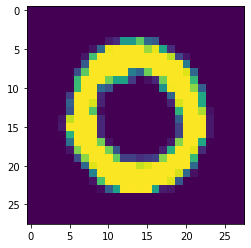

In [10]:
trainData = pd.read_csv("./MNIST_train.csv")
train_y = trainData['label'].to_numpy()
train_x = trainData.to_numpy()
#The first column is the label column so we will remove that
train_x = train_x[:,1:train_x.shape[1]]
#turn our data into torch tensors
train_y = torch.from_numpy(train_y)
train_x = torch.from_numpy(train_x)
#We now need to reshape train_x so that it is in the correct format for the image classifier
train_x = train_x.view(train_x.shape[0], 1, int(np.sqrt(train_x.shape[1])), int(np.sqrt(train_x.shape[1])))

#Now we'll look an image and write a function that will take a tensor and show the plot of the image
import matplotlib.pyplot as plt

def TImShow(image):
    image = image[0,:,:]
    plt.imshow(image.cpu().detach().numpy())
    plt.show()
TImShow(train_x[1,:,:,:])

In [11]:
# For reproducability
torch.manual_seed(1)
# Define the critic/discriminator model
class Discriminator(nn.Module):
    #Note that exImg will contain and example image which we can get the dimension of NOTE: this should have dimension (1, 1, height, width)
    #batchSize will be the size of the batches
    def __init__(self, exImg):
        super(Discriminator, self).__init__()
        # The article uses same padding, which is not trivial to implement in pytorch. We will use the padding function with 
        #p = (filter size - 1)/2 = 1 to get same padding
        self.inputImg = exImg
        self.conv1 = nn.Conv2d(1, 64, 3, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 64, 3, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.leReLU = nn.LeakyReLU(.2)
        self.fc1 = nn.Linear(3136, 1)

    def forward(self, x):
        x = self.leReLU(self.conv1(x))
        x = self.batchNorm1(x)
        x = self.leReLU(self.conv2(x))
        x = self.batchNorm2(x)
        # Remember that view reshapes the tensor, so this is a flattening layer since it contains a -1 we will get an output shape of
        # (nSamples, nChannels * number of features (which has changed from the original due to the convolutions and pooling))
        x = x.view(-1, self.num_flat_features(x))
        x = self.fc1(x)
        return x
    #Gets the number of features after all of the dimensionality reduction is applied to x from the convolutions and maxpoolings
    def num_flat_features(self, x):
        # x's shape is originally nSamples, nChannels, Height, Width for images, so we want to compute nChannels * num features = 
        # nChannels * Current Height * Current Width (current referring to after conv and pooling)
        size = x.shape[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
#load full data into python, no need to split into test and train since this is not about accuracy
train_y = trainData['label'].to_numpy()
train_x = trainData.to_numpy()
train_x = train_x[:,1:train_x.shape[1]]
#turn our data into torch tensors
train_y = torch.from_numpy(train_y)
train_x = torch.from_numpy(train_x)
#We now need to reshape train_x so that it is in the correct format for the image classifier
train_x = train_x.view(train_x.shape[0], 1, int(np.sqrt(train_x.shape[1])), int(np.sqrt(train_x.shape[1])))
batch_size = 32
exImg = train_x[0,:,:,:].view(1,1,28,28)
dis = Discriminator(exImg)
dis.cuda()
print(dis)

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.leReLU = nn.LeakyReLU(.2)
        #Start with a 100 variable input from the latent space, and turn it into 7x7x128 linear vector (we'll reshape this next in the forward pass)
        self.fc1 = nn.Linear(100, 7*7*128)
        #next we need to upsample with a transposed convolution
        self.tConv1 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm1 = nn.BatchNorm2d(128)
        self.tConv2 = nn.ConvTranspose2d(128, 128, 4, stride = 2, padding = 1)
        self.batchNorm2 = nn.BatchNorm2d(128)
        self.conv1 = nn.Conv2d(128, 1, 7, padding = 3)
        #this must have output dimension equal to the image
        
    def forward(self, x):
        x = self.leReLU(self.fc1(x))
        x = x.view(-1,128,7,7) #working with 7x7 images
        x = self.leReLU(self.batchNorm1(self.tConv1(x))) #upscale to 14x14
        x = self.leReLU(self.batchNorm2(self.tConv2(x))) #upscale to 28x28
        x = torch.tanh(self.conv1(x))
        return x
gen = Generator()
gen.cuda()
print(gen)

Discriminator(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=3136, out_features=1, bias=True)
)
Generator(
  (leReLU): LeakyReLU(negative_slope=0.2)
  (fc1): Linear(in_features=100, out_features=6272, bias=True)
  (tConv1): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tConv2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batchNorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(128, 1, kernel_size=(7, 7), s

The generator's first attempt at generating an image: 


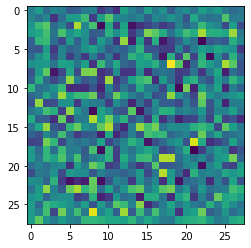

[20,   131] loss: 10.596


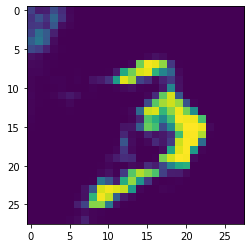

[40,   131] loss: 9.979


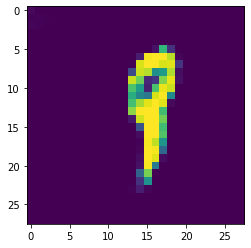

[60,   131] loss: 9.177


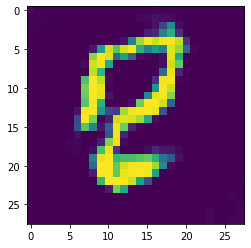

[80,   131] loss: 8.555


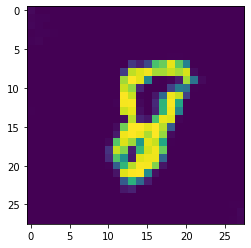

[100,   131] loss: 8.160


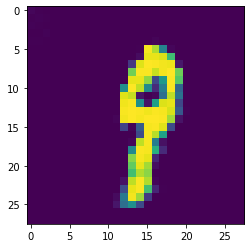

[120,   131] loss: 8.033


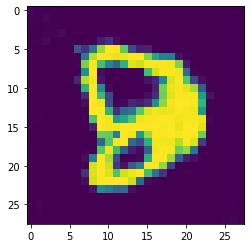

[140,   131] loss: 7.739


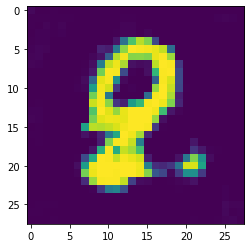

[160,   131] loss: 7.728


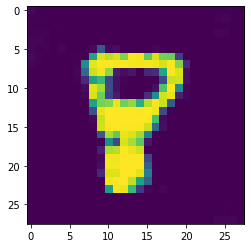

[180,   131] loss: 7.516


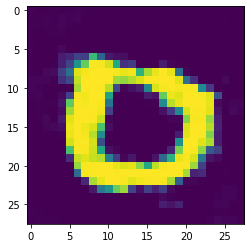

[200,   131] loss: 7.376


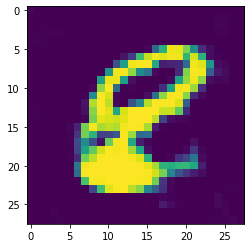

Done traininig


In [12]:
def getRealSamples(data, batch_size):
    temp = torch.randperm(batch_size)
    result = data[temp, :, :, :]
    #rescale to match generator, normall grey scale ranges from [0,255], so to do this rescale we will subtrack by the mid point and divide by the mid point
    #(this will force all the values to be between -1 and 1)
    result = result.float()
    result = (result - 255/2)/(255/2)
    return result
#define our two optimizers
learning_rate = 5e-5
#Use two separate RMSprop optimizers, one for the generator and one for the discriminator
gOptimizer = torch.optim.RMSprop(gen.parameters(), lr=learning_rate)
dOptimizer = torch.optim.RMSprop(dis.parameters(), lr=learning_rate)
#Now we will define the training loop:
epochs = 200
batchesPerEpoch = int(np.floor(train_x.shape[0]/10/batch_size))
for epoch in range(epochs):
    running_gen_loss = 0
    for i in range(batchesPerEpoch):
        #number of times we train the critic for each training step on the generator
        criticConst = 5
        for j in range(criticConst):
            #set the gradients of the discriminator to zero
            dOptimizer.zero_grad()
            #generate a mini batch of gaussian noise
            genMiniBatch = torch.rand(batch_size, 100).float()
            genMiniBatch = genMiniBatch.cuda()
            #get a minibatch of the real data
            realMiniBatch = getRealSamples(train_x, batch_size)
            realMiniBatch = realMiniBatch.cuda()

            #Start by training the discriminator
            #Get Dx, the discriminator when applied to the minibatch of real data
            Dx = dis(realMiniBatch)
            #calculate the loss associated with this step
            dxLoss = -1*torch.mean(Dx)
            #find the gradients for this step
            dxLoss.backward()
            #generate fake images
            Gz = gen(genMiniBatch.float())
            #apply the discriminator to fake images
            Gz = Gz.view(batch_size, 1, 28, 28)
            Gz = Gz.cuda()
            DGz = dis(Gz)
            #Find the loss associated with this step
            dgzLoss = 1*torch.mean(DGz)
            #Accumulate the gradients for this half of the loss
            dgzLoss.backward()
            #set the total loss as the sum of our two previous losses
            dLoss = dgzLoss+dxLoss
            dOptimizer.step()
            #weight clipping. I used https://discuss.pytorch.org/t/set-constraints-on-parameters-or-layers/23620/7 as a reference
            #it appears that j.data will allow us to modify non-leaf nodes of our computational graph despite the fact that they require gradients. 
            #It also appears that this feature is depreciated, and it shouldn't be used until after our optimizer has taken a step because it might mess 
            #with the backpropogation. Note: the .clamp_ function does exactly what one would think (it makes sure that all the values of a tensor are 
            #within the given range) and the _ denotes that the operation is an inplace operation.
            for j in dis.parameters():
                j.data.clamp_(-.1,.1)
        
        
        #set the generator's gradients to zero
        gOptimizer.zero_grad()
        genMiniBatch = torch.rand(batch_size*2, 100)
        genMiniBatch = genMiniBatch.cuda()
        #use the generator to make a new batch of images (even though we have already computed this we need to recompute it for pytorch to understand 
        #how to backpropogate)
        Gz = gen(genMiniBatch.float())
        #apply the discriminator to the generated images
        Gz = Gz.view(batch_size*2, 1, 28, 28)
        Gz = Gz.cuda()
        DGz = dis(Gz)
        #calculate the loss
        gLoss = -1*torch.mean(DGz)
        #accumulate the gradients
        gLoss.backward()
        gOptimizer.step()
            
        if epoch == 0 and i == 0:
            print("The generator's first attempt at generating an image: ")
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
        # print statistics and image
        running_gen_loss += gLoss.item()
        if i == batchesPerEpoch-1 and epoch%20 == 19:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_gen_loss/batchesPerEpoch))
            Gz = Gz.view(batch_size*2,1,28,28)
            TImShow(Gz[0,:,:,:])
            #running_gen_loss = 0.0
                
print("Done traininig")

### Final Thoughts on GANs Using the Complete Dataset
It doesn't appear to converge to a single solution, and this is probably due to the fact that I am using Wasserstein loss. I could probably get the mode collapse behavior if I used the original paper's loss, or maybe just a more complex dataset, but for now I think that my implementation is somewhat stable for this data set. It does seem to take longer to converge to a consistently good solution, a lot of the things it prints seem to be mixes of multiple digits rather than 1 cohesive digit.


## Summary of this Progress Report
In this progress report I learned how to apply deep learning techniques to 2 more types of data: sequential (text) and tabular. LSTMs presented an interesting solution to sequential models’ tendency to "forget" the beginning of an input sequence through their use of gates which allowed them to curate what information they thought was important throughout the model. This exercise was not only useful for my own learning, but also helped me understand attention in neural networks. I then turned to implementing TabNet which uses ideas from many different domains in machine learning to provide a framework for working with tabular data using deep learning. It did this through an attention mechanism that allowed the neural net to simulate a decision tree through the use of masks. I had originally intended to do more "exploitation" of techniques this week, but implementing TabNet turned out to be a much larger undertaking than I had originally thought, involving multiple papers, a new layer type (see ghost batch normalization), and a new activation function (see sparse max), so I ran out of time. I hope next week to apply some of these techniques to data that interests me and pertains to my research outside of class, but for this week I believe that this work is sufficient. Additionally, I quickly addressed feedback with my previous biweekly report by learning how to read and access the CIFAR-10 data set and running my GAN on the complete MNIST data set, which did not exhibit mode collapse due to my use of Wasserstein loss.
